<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/DDN_Cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://github.com/GeoZcx/A-deeply-supervised-image-fusion-network-for-change-detection-in-remote-sensing-images

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
from PIL import Image

In [3]:
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same',droprate=0.3):
    x = tf.keras.layers.Conv2D(nb_filter, kernel_size, padding=padding, strides=strides,activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Dropout(rate = droprate)(x)
    return x

def attach_attention_module(net, attention_module):
    if attention_module == 'se_block':  # SE_block
        net = se_block(net)
    elif attention_module == 'cbam_block':  # CBAM_block
        net = cbam_block(net)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_module))

    return net


def se_block(input_feature, ratio=8):
    """Contains the implementation of Squeeze-and-Excitation(SE) block.
    As described in https://arxiv.org/abs/1709.01507.
    """

    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    se_feature = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    se_feature = tf.keras.layers.Reshape((1, 1, channel))(se_feature)
    assert se_feature.shape[1:] == (1, 1, channel)
    se_feature = tf.keras.layers.Dense(channel // ratio,
                       activation='relu',
                       kernel_initializer='he_normal',
                       use_bias=True,
                       bias_initializer='zeros')(se_feature)
    assert se_feature.shape[1:] == (1, 1, channel // ratio)
    se_feature = tf.keras.layers.Dense(channel,
                       activation='sigmoid',
                       kernel_initializer='he_normal',
                       use_bias=True,
                       bias_initializer='zeros')(se_feature)
    assert se_feature.shape[1:] == (1, 1, channel)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = tf.keras.layers.Permute((3, 1, 2))(se_feature)

    se_feature = input_feature*se_feature
    return se_feature


def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = tf.keras.layers.Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = tf.keras.layers.Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = tf.keras.layers.Reshape((1, 1, channel))(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel // ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)

    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = tf.keras.layers.Reshape((1, 1, channel))(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel // ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)

    cbam_feature = avg_pool + max_pool
    cbam_feature = tf.keras.layers.Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = tf.keras.layers.Permute((3, 1, 2))(cbam_feature)

    return input_feature * cbam_feature


def spatial_attention(input_feature):
    kernel_size = 7

    if tf.keras.backend.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = tf.keras.layers.Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = tf.keras.layers.Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = tf.keras.layers.Permute((3, 1, 2))(cbam_feature)

    return input_feature * cbam_feature


def get_spatial_attention_map(input_feature):
    kernel_size = 7
    cbam_feature = input_feature

    avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = tf.keras.layers.Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = tf.keras.layers.Permute((3, 1, 2))(cbam_feature)

    return cbam_feature

#Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
if not(os.path.isdir("/content/Kaggle_CoverChange")):
  shutil.unpack_archive("/content/drive/MyDrive/Kaggle_CoverChange.zip","/content/")

In [95]:
data_dir = "/content/Kaggle_CoverChange"
list_ds = tf.data.Dataset.list_files(str(data_dir+"/im1/*"),shuffle=False)
#dataset is made up of strings
oh_label = False
out_list = True
out_layers = 5
concat_and_mask = True

In [7]:

#classes = array([ 29.,  38.,  75.,  76., 128., 150., 255.])
class_dict = {(29):1, (38):2, (75):3,(76):3,128:4,150:5,(255):0} #mapping 75 and 76 to same class, i'm assuming this is an encoding issue.

def to_categorical(tensor,class_dict):
  #maps pixel values to categories 1,2...num_classes
  for k,v in class_dict.items():
    tensor[tensor==k]=v
  return tensor

In [8]:
label1_fn = "/content/Kaggle_CoverChange/label1/00003.png"
label1 = tf.keras.preprocessing.image.load_img(label1_fn,color_mode="grayscale")
label1 = tf.keras.preprocessing.image.img_to_array(label1)

##Testing label change conversion

In [9]:
num_classes = 6

##Need to convert 2 labels into 1 change label

Trick: Let n be number of classes
Step 1. Use an outer product between one_hot encoded labels
(h,w,n),(h,w,n)->(h,w,n,n), this is gives a one hot encoded change matrix M.

Eg. M = 0 except for Mij = 1 -> class i changed to class j.

Step 2. Convert to categorical change -> (h,w,n,n)->(h,w,n^2)

In [10]:
"""#converting (label1,label2)->(label changemap)
#where change map has num_classes^2 (not all unique) change classes 
def make_label_change_dict(num_classes):
  label_change_dict = {}
  i = 0
  for x in range(num_classes):
    for y in range(num_classes):
      label_change_dict[(x,y)] = i *(x!=y)
      i += 1
  return label_change_dict

label_change_dict = make_label_change_dict(6)
print(label_change_dict)"""

#converting (label1,label2)->(label changemap)
#where change map has num_classes^2 (not all unique) change classes 
def make_label_change_array(num_classes):
  """Arg:
  num_classes:int, number of classes
  returns:
  num_classes^2 matrix of categorical change labels.
  """
  label_change_arr = np.zeros((num_classes,num_classes),dtype=np.uint8)
  i = 0
  for x in range(num_classes):
    for y in range(num_classes):
      label_change_arr[x,y] = i *(x!=y)
      i += 1
  return label_change_arr

label_change_arr = make_label_change_array(6)

print(label_change_arr)

[[ 0  1  2  3  4  5]
 [ 6  0  8  9 10 11]
 [12 13  0 15 16 17]
 [18 19 20  0 22 23]
 [24 25 26 27  0 29]
 [30 31 32 33 34  0]]


In [11]:
def get_class_change_label(before,after,label_change_arr):
  """
  Input:
  two np.array or tf.tensor of shape (batch,Width,Height, num_classes) corresponding to class labeled data in one hot encoding
  the arrays represent the before and after class labels for change detection
  Output:
  a np.array of shape (batch,Width,Height) corresponding to change labels (see figure 2)
  """
  labels_combined = np.einsum("abd,abe->abde",before,after)
  labels_combined = labels_combined*label_change_arr
  labels_combined = np.sum(labels_combined, axis=(-1,-2))
  return labels_combined

In [12]:
label1_fn = "/content/Kaggle_CoverChange/label1/00018.png"
label2_fn = "/content/Kaggle_CoverChange/label2/00018.png"

##Testing change label generation trick

In [13]:
 """   label1 = tf.keras.preprocessing.image.load_img(label1_fn, color_mode="grayscale")
    label1 = tf.keras.preprocessing.image.img_to_array(label1)
    label1old = label1
    label1 = to_categorical(label1,class_dict)
    label1 = tf.expand_dims(label1,axis=0)
    label1 = tf.one_hot(tf.cast(label1[:,:,:,0],dtype = tf.uint8),depth = num_classes)




    label2 = tf.keras.preprocessing.image.load_img(label2_fn, color_mode ="grayscale")
    label2 = tf.keras.preprocessing.image.img_to_array(label2)
    label1old = label1
    label2 = to_categorical(label2,class_dict)
    label2 = tf.expand_dims(label2,axis=0)
    label2old = label2
    label2 = tf.one_hot(tf.cast(label1[:,:,:,0],dtype = tf.uint8),depth=num_classes)

    print(label1.shape)
    print(label2.shape)
    print(label1[0,300,300,:])
    print(label2[0,300,300,:])
    lc = np.einsum("abcd,abce->abcde",label1,label2)

    print(lc[0,300,300,:,:])
    lc = lc * label_change_arr
    print(lc[0,300,300,:,:])"""

'   label1 = tf.keras.preprocessing.image.load_img(label1_fn, color_mode="grayscale")\n   label1 = tf.keras.preprocessing.image.img_to_array(label1)\n   label1old = label1\n   label1 = to_categorical(label1,class_dict)\n   label1 = tf.expand_dims(label1,axis=0)\n   label1 = tf.one_hot(tf.cast(label1[:,:,:,0],dtype = tf.uint8),depth = num_classes)\n\n\n\n\n   label2 = tf.keras.preprocessing.image.load_img(label2_fn, color_mode ="grayscale")\n   label2 = tf.keras.preprocessing.image.img_to_array(label2)\n   label1old = label1\n   label2 = to_categorical(label2,class_dict)\n   label2 = tf.expand_dims(label2,axis=0)\n   label2old = label2\n   label2 = tf.one_hot(tf.cast(label1[:,:,:,0],dtype = tf.uint8),depth=num_classes)\n\n   print(label1.shape)\n   print(label2.shape)\n   print(label1[0,300,300,:])\n   print(label2[0,300,300,:])\n   lc = np.einsum("abcd,abce->abcde",label1,label2)\n\n   print(lc[0,300,300,:,:])\n   lc = lc * label_change_arr\n   print(lc[0,300,300,:,:])'

##Testing over

##Data processing

*   Load as string dataset of filenames
*   map get_item() to create dataset of (image1,image2, change labels)
*   apply other pipeline steps (batching, shuffling, transformations)
 

Tricks:

Creating 1 change map from 2 labels:


*   one hot encode the labels
*   use an outer produce to produce a one-hot change matrix
*   flatten for one hot change matrix, or use broadcast a change_array see make_label_change_array
*   convert to categorical as needed

Creating 2 change maps from 2 change labels:


*   one hot encode labels
*   substract label 2 from label 1, l3 = l1-l2
*   l3 == 1 correspond to elements removed from label 1
*   l3 == -1 correspond to elements added by label 2







In [53]:
def get_item(path):
  """
  returns 3 tensors when called in a dataset.map
  """

  #wrap function in tf.numpy_function() or tf.data.dataset.map bugs out

  def _get_item(path):
    """
    args:
    path: Dataset.list_file dataset element

    returns: 
    (h,w,3),(h,w,1),(h,w,3),(h,w,1) image-label 4-tuple in tf.float32 tf.Tensor
    """

    fn = tf.strings.split(path,"/")
    base_dir = tf.strings.join(fn[:-2],separator="/")

    image1_fn = (base_dir+"/im1/"+fn[-1]).numpy()
    image2_fn = (base_dir+"/im2/"+fn[-1]).numpy()

    label1_fn = (base_dir+"/label1/"+fn[-1]).numpy()
    label2_fn = (base_dir+"/label2/"+fn[-1]).numpy()

    #label1_fn = "/content/Kaggle_CoverChange/label1/00018.png"
    #label2_fn = "/content/Kaggle_CoverChange/label2/00018.png"


    image1 = tf.keras.preprocessing.image.load_img(image1_fn)
    image1 = tf.keras.preprocessing.image.img_to_array(image1)

    image2 = tf.keras.preprocessing.image.load_img(image2_fn)
    image2 = tf.keras.preprocessing.image.img_to_array(image2)

    label1 = tf.keras.preprocessing.image.load_img(label1_fn, color_mode="grayscale")
    label1 = tf.keras.preprocessing.image.img_to_array(label1)
    label1 = to_categorical(label1,class_dict)
    #label1 = tf.expand_dims(label1,axis=0)

    label1 = tf.one_hot(tf.cast(label1[:,:,0],dtype = tf.uint8),depth = num_classes)




    label2 = tf.keras.preprocessing.image.load_img(label2_fn, color_mode ="grayscale")
    label2 = tf.keras.preprocessing.image.img_to_array(label2)
    label2 = to_categorical(label2,class_dict)
    #label2 = tf.expand_dims(label2,axis=0)

    label2 = tf.one_hot(tf.cast(label2[:,:,0],dtype = tf.uint8),depth=num_classes)

    change_label = get_class_change_label(label1,label2,label_change_arr=label_change_arr)
    
    if oh_label:
      change_label = tf.one_hot(tf.cast(change_label[:,:],dtype = tf.uint8),depth=num_classes**2-1)
    else:
      change_label = tf.expand_dims(change_label, axis=-1)
    """
    #doesn't work, errors on backend when passing datasets from list of tensors of different size
    if out_list:
      y_list = [change_label]
      change_label = tf.expand_dims(change_label,axis=0)
      for i in range(out_layers):
        
        change_label = tf.keras.layers.MaxPool2D()(change_label)
        y_list.append(change_label.numpy()[0,:,:,:])
      change_label = tf.ragged.constant(y_list)
    """

    #classes = array([ 29.,  38.,  75.,  76., 128., 150., 255.])
    #(h,w,1) tensor of int from 1-6
    

    return image1,image2,change_label

  output = tf.numpy_function(_get_item,[path],[tf.float32,tf.bool,tf.bool])

  return output

In [89]:
def two_labels_to_twochanges(l1,l2):
  """
  args:
  l1,l2 one_hot encoded labels
  returns: l3, l4, mask: one_hot encoded labels of changes and change mask
  eg (categorical version) : if at a pixel p :
   l1 == 1, l2 == 1 => l3 = 0, l4 = 0
   but instead
   l1 == 1, l2 == 2 => l3 = 1, l4 = 2
  """
  lmixed = l1 - l2
  l3 = lmixed == 1 
  l4 = lmixed == -1
  mask = lmixed != 0
  return l3, l4

def get_item2(path):
  """
  returns 4 tensors: image1,image2, (label1,label2), change mask
  when called inside a dataset.map
  """

  #wrap function in tf.numpy_function() or tf.data.dataset.map bugs out

  def _get_item2(path):
    """
    args:
    path: Dataset.list_file dataset element

    returns: 
    (h,w,3),(h,w,1),(h,w,3),(h,w,1) image-label 4-tuple in tf.float32 tf.Tensor
    """

    fn = tf.strings.split(path,"/")
    base_dir = tf.strings.join(fn[:-2],separator="/")

    image1_fn = (base_dir+"/im1/"+fn[-1]).numpy()
    image2_fn = (base_dir+"/im2/"+fn[-1]).numpy()

    label1_fn = (base_dir+"/label1/"+fn[-1]).numpy()
    label2_fn = (base_dir+"/label2/"+fn[-1]).numpy()

    #label1_fn = "/content/Kaggle_CoverChange/label1/00018.png"
    #label2_fn = "/content/Kaggle_CoverChange/label2/00018.png"


    image1 = tf.keras.preprocessing.image.load_img(image1_fn)
    image1 = tf.keras.preprocessing.image.img_to_array(image1)

    image2 = tf.keras.preprocessing.image.load_img(image2_fn)
    image2 = tf.keras.preprocessing.image.img_to_array(image2)

    label1 = tf.keras.preprocessing.image.load_img(label1_fn, color_mode="grayscale")
    label1 = tf.keras.preprocessing.image.img_to_array(label1)
    label1 = to_categorical(label1,class_dict)
    #label1 = tf.expand_dims(label1,axis=0)
    label1 = tf.one_hot(tf.cast(label1[:,:,0],dtype = tf.uint8),depth = num_classes)


    label2 = tf.keras.preprocessing.image.load_img(label2_fn, color_mode ="grayscale")
    label2 = tf.keras.preprocessing.image.img_to_array(label2)
    label2 = to_categorical(label2,class_dict)
    #label2 = tf.expand_dims(label2,axis=0)
    label2 = tf.one_hot(tf.cast(label2[:,:,0],dtype = tf.uint8),depth=num_classes)

    label1,label2 = two_labels_to_twochanges(label1,label2) #(1,H,W,num_classes)
    

    if not(oh_label):
      label1 = tf.argmax(label1, axis=-1,output_type=tf.int32)
      label1 = tf.expand_dims(label1,axis=-1)
      label2 = tf.argmax(label2, axis=-1,output_type=tf.int32)
      label2 = tf.expand_dims(label2,axis=-1)

    change_label = tf.concat([label1,label2],axis=-1) #(1,512,512, 2*num_class) if one_hot, (1,512,512,2) otherwise
    change_mask = change_label != 0
    change_mask = tf.cast(change_mask,tf.int32)
      
    """
    #doesn't work, errors on backend when passing datasets from list of tensors of different size
    if out_list:
      y_list = [change_label]
      change_label = tf.expand_dims(change_label,axis=0)
      for i in range(out_layers):
        
        change_label = tf.keras.layers.MaxPool2D()(change_label)
        y_list.append(change_label.numpy()[0,:,:,:])
      change_label = tf.ragged.constant(y_list)
    """

    #classes = array([ 29.,  38.,  75.,  76., 128., 150., 255.])
    #(h,w,1) tensor of int from 1-6
    

    return image1,image2,change_label,change_mask

  output = tf.numpy_function(_get_item2,[path],[tf.float32,tf.float32,tf.int32,tf.int32])

  return output

In [119]:
def transform(x1,x2,y):
  """
  Write your data transformations here
  """
  x1=tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)(x1)
  x2=tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)(x2)
  #y=tf.one_hot(tf.cast(y[:,:,0],dtype = tf.int32),depth = 7)
  """
  if out_list:
    y_list = [y]
    for i in range(out_layers):
      y = tf.keras.layers.MaxPool2D()(y)
      y_list.append(y)
    y = tf.ragged.constant(y_list)
    """
    

  return x1,x2,y

def transform2(x1,x2,y1,y2):
  """
  Write your data transformations here
  """
  x1=tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)(x1)
  x2=tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)(x2)
  #y=tf.one_hot(tf.cast(y[:,:,0],dtype = tf.int32),depth = 7)
  """
  if out_list:
    y_list = [y]
    for i in range(out_layers):
      y = tf.keras.layers.MaxPool2D()(y)
      y_list.append(y)
    y = tf.ragged.constant(y_list)
    """
    

  return x1,x2,y1,y2

def preprocessing(list_ds,batch_size=8,augmentation=transform):
  """
  applies some preprocessing
  args:
  list_ds-Dataset.list_files dataset object
  batch_size-int 
  augmentation-a function (x,y)->(x,y)
  returns-batched dataset
  """

  #ds = list_ds.cache() 
  if concat_and_mask:
    ds = list_ds.map(get_item2,num_parallel_calls=tf.data.AUTOTUNE) 
    ds = ds.batch(batch_size,drop_remainder=True)
    ds = ds.shuffle(100)

    if augmentation:
      ds = ds.map((lambda x1,x2,y1,y2 : augmentation(x1,x2,y1,y2)),num_parallel_calls=tf.data.AUTOTUNE)
      
  else:
    ds = list_ds.map(get_item,num_parallel_calls=tf.data.AUTOTUNE) 
    ds = ds.batch(batch_size,drop_remainder=True)
    ds = ds.shuffle(100)
    if augmentation:
      ds = ds.map((lambda x,y,z : augmentation(x,y,z)),num_parallel_calls=tf.data.AUTOTUNE)
      


  
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds



#load pretrained model

In [16]:
if not(os.path.isdir("/content/Drive/Saved_Model/")):
  shutil.unpack_archive("/content/drive/MyDrive/vgg_512_seg_model.zip","/content/Drive/Saved_Model/")

##Test

In [17]:
"""
vgg16_512 = tf.keras.models.load_model("/content/Drive/Saved_Model")
vgg16_512.summary()

feature_layers = [vgg16_512.get_layer("features_c1"),vgg16_512.get_layer("features_c2"),vgg16_512.get_layer('features_c3'),vgg16_512.get_layer('features_c4'),vgg16_512.get_layer('features_c5')]
feature_extractor = tf.keras.models.Model(inputs = vgg16_512.input, outputs = [layer.output for layer in feature_layers])

test_tensor = tf.random.normal((1,512,512,3))
test_out = feature_extractor(test_tensor)
for t in test_out:
  print(t.shape)
"""

'\nvgg16_512 = tf.keras.models.load_model("/content/Drive/Saved_Model")\nvgg16_512.summary()\n\nfeature_layers = [vgg16_512.get_layer("features_c1"),vgg16_512.get_layer("features_c2"),vgg16_512.get_layer(\'features_c3\'),vgg16_512.get_layer(\'features_c4\'),vgg16_512.get_layer(\'features_c5\')]\nfeature_extractor = tf.keras.models.Model(inputs = vgg16_512.input, outputs = [layer.output for layer in feature_layers])\n\ntest_tensor = tf.random.normal((1,512,512,3))\ntest_out = feature_extractor(test_tensor)\nfor t in test_out:\n  print(t.shape)\n'

#DDN

In [18]:
#vgg16_512 = tf.keras.models.load_model("/content/Drive/Saved_Model")
#vgg16_512.summary()

In [19]:
def DDN (imsize, num_classes = 6):
    #if input image 512*512

    vgg16_512 = tf.keras.models.load_model("/content/Drive/Saved_Model")

    image1 = tf.keras.layers.Input((imsize,imsize,3),name = "image1")
    image2 = tf.keras.layers.Input((imsize,imsize,3),name = "image2")

    feature_layers = [vgg16_512.get_layer("features_c1"),vgg16_512.get_layer("features_c2"),vgg16_512.get_layer('features_c3'),vgg16_512.get_layer('features_c4'),vgg16_512.get_layer('features_c5')]
    feature_extractor = tf.keras.models.Model(inputs = vgg16_512.input, outputs = [layer.output for layer in feature_layers],trainable=True)

    features_1 = feature_extractor(image1)
    features_2 = feature_extractor(image2)

    t1_b5c3 = features_1[4] #(None, 32, 32, 512)
    t2_b5c3 = features_2[4] 

    t1_b4c3 = features_1[3] #(None, 64, 64, 512)
    t2_b4c3 = features_2[3] 
    
    t1_b3c3 = features_1[2] #(None, 128, 128, 256)  
    t2_b3c3 = features_2[2]

    t1_b2c2 = features_1[1]
    t2_b2c2 = features_2[1] #(None, 256, 256, 128) 

    t1_b1c2 = features_1[0]
    t2_b1c2 = features_2[0] #(None, 512, 512, 64)


    """
    pair5 = tf.keras.layers.Input((imsize,imsize,64*2), name='pair5') #rbg images concatenated channel-wise
    pair4 = tf.keras.layers.Input((imsize//2,imsize//2,128*2), name='pair4')
    pair3 = tf.keras.layers.Input((imsize//4,imsize//4,256*2), name='pair3')
    pair2 = tf.keras.layers.Input((imsize//8,imsize//8,512*2), name='pair2')
    pair1 = tf.keras.layers.Input((imsize//16,imsize//16,512*2), name='pair1')


    t1_b5c3 = pair1[:,:,:,:3] #(None, 32, 32, 512)
    t2_b5c3 = pair1[:,:,:,3:] 

    t1_b4c3 = pair2[:,:,:,:3] #(None, 64, 64, 512)
    t2_b4c3 = pair2[:,:,:,3:] 
    
    t1_b3c3 = pair3[:,:,:,:3] #(None, 128, 128, 256)  
    t2_b3c3 = pair3[:,:,:,3:]

    t1_b2c2 = pair4[:,:,:,:3]
    t2_b2c2 = pair4[:,:,:,3:] #(None, 256, 256, 128) 

    t1_b1c2 = pair5[:,:,:,:3]
    t2_b1c2 = pair5[:,:,:,3:] #(None, 512, 512, 64)
    """

    concat_b5c3 = tf.keras.layers.concatenate([t1_b5c3, t2_b5c3], axis=3) #channel 1024
    x = Conv2d_BN(concat_b5c3,256, 3)
    x = Conv2d_BN(x,128,3)
    attention_map_1 = get_spatial_attention_map(x)
    x = x * attention_map_1
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branche1
    branch_1 =tf.keras.layers.Conv2D(num_classes**2-1, kernel_size=1, padding='same',name='output_32')(x)

    x = tf.keras.layers.Conv2DTranspose(imsize, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(x)
    x = tf.keras.layers.concatenate([x,t1_b4c3,t2_b4c3],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,256,3)
    x = Conv2d_BN(x,128,3)
    x = Conv2d_BN(x,64,3)
    attention_map_2 = get_spatial_attention_map(x)
    x = x *attention_map_2
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branche2
    branch_2 =tf.keras.layers.Conv2D(num_classes**2-1, kernel_size=1, padding='same',name='output_64')(x)

    x = tf.keras.layers.Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(x)
    x = tf.keras.layers.concatenate([x,t1_b3c3,t2_b3c3],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,256,3)
    x = Conv2d_BN(x,128,3)
    x = Conv2d_BN(x, 64, 3)
    attention_map_3 = get_spatial_attention_map(x)
    x = x * attention_map_3
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branche3
    branch_3 =tf.keras.layers.Conv2D(num_classes**2-1, kernel_size=1, padding='same',name='output_128')(x)

    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(x)
    x = tf.keras.layers.concatenate([x,t1_b2c2,t2_b2c2],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,128,3)
    x = Conv2d_BN(x,64,3)
    x = Conv2d_BN(x, 32, 3)
    attention_map_4 = get_spatial_attention_map(x)
    x = x * attention_map_4
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branche4
    branch_4 =tf.keras.layers.Conv2D(num_classes**2-1, kernel_size=1, padding='same',name='output_256')(x)

    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(x)
    x = tf.keras.layers.concatenate([x,t1_b1c2,t2_b1c2],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,64,3)
    x = Conv2d_BN(x,32,3)
    x = Conv2d_BN(x, 16, 3)
    attention_map_5 = get_spatial_attention_map(x)
    x = x * attention_map_5

    # branche5
    branch_5 =tf.keras.layers.Conv2D(num_classes**2-1, kernel_size=1, padding='same',name='output_imsize')(x)

    DDN = tf.keras.models.Model(inputs=[image1,image2], outputs=[branch_5,branch_4,branch_3,branch_2,branch_1])

    return DDN

In [20]:
#TEST
"""
imsize = 512
image1 = tf.random.normal((1,512,512,3))
image2 = tf.random.normal((1,512,512,3))
ddn = DDN(512,6)
forward = ddn([image1,image2])
for f in forward:
  print (f.shape)"""

'\nimsize = 512\nimage1 = tf.random.normal((1,512,512,3))\nimage2 = tf.random.normal((1,512,512,3))\nddn = DDN(512,6)\nforward = ddn([image1,image2])\nfor f in forward:\n  print (f.shape)'

In [21]:
ddn = DDN(512,6)
ddn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image1 (InputLayer)             [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
image2 (InputLayer)             [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 512, 512, 64 14714688    image1[0][0]                     
                                                                 image2[0][0]                     
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 1024) 0           model[0][4]                

#Defining loss and metrics
Using Pooling layers to reduce target image size for deep supervision

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, warmup_steps=20, base_lr=0.01):
    super(CustomSchedule, self).__init__()

    self.base_lr = base_lr
    self.warmup_steps = tf.cast(warmup_steps,tf.float32)

  def __call__(self, step):
    step = tf.cast(step,tf.float32)
    arg1 = 1/step
    arg2 = step * (self.warmup_steps ** -1.5)

    return self.base_lr * tf.math.minimum(arg1, arg2)

In [23]:
lr_schedule = CustomSchedule(base_lr = 0.3)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
#train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

if oh_label:

  entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)#adds a softmax step
else: 
  entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)

In [24]:
class_weights = np.ones((512,512,num_classes**2-1))
class_weights[:,:,0]= 1/3 #class 0 corresponds to no change

In [25]:
def dice_loss (y_true,y_pred,eps = 1e-5,num_classes=6):
  #y_true = y_true[:,:,:,0]
  y_pred = tf.nn.softmax(y_pred)
  
  #y_pred = tf.argmax(y_pred,axis=-1)
  #y_true = tf.one_hot(tf.cast(y_true,dtype = tf.uint8),depth = num_classes**2-1)
  return tf.math.reduce_mean(1 - (2*y_true*y_pred)/(y_true + y_pred + eps))

In [26]:
def DS_loss_fn(y_true, y_pred, loss_function = entropy, layer_weights=[3,1,1,1,1],class_weights = tf.ones((35))):
  """
  Deep supervision loss
  Args:
  y_true-one hot encoded ground truth (n,H,W,n_classes^2-1)
  y_pred-list of predictions [imsize,imsize/2,imsize/4,imsize/8,imsize/16]
  loss_function = tf.keras loss function object
  layer_weights = list of 5 int
  class_weights = list of int broadcastable to y_true
  """
  loss = 0
  y_true = y_true * class_weights
  for i in range(len(layer_weights)):

    loss = loss+ tf.math.reduce_mean(layer_weights[i]*loss_function(y_true,y_pred[i]) + layer_weights[i]*dice_loss (y_true, y_pred[i]))
    #loss = loss+ tf.math.reduce_mean(layer_weights[i]*dice_loss (y_true, y_pred[i]))
    #loss = loss+ layer_weights[i]*loss_function(y_true,y_pred[i])
    y_true = tf.keras.layers.MaxPool2D()(y_true) 
  return loss

In [27]:
##Test
"""
y_pred = ddn([test_im1,test_im2])
DS_loss_fn(test_label,y_pred)"""

'\ny_pred = ddn([test_im1,test_im2])\nDS_loss_fn(test_label,y_pred)'

In [28]:
save_path = "/content/Saved_Models/"
if not(os.path.isdir(save_path)):
  os.mkdir(save_path)
batch_size = 1
epochs = 1
model_savename="DDN_test"


##Tensorboard

In [29]:
%load_ext tensorboard
import datetime

In [30]:
# Clear any logs from previous runs
!rm -rf ./logs/

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [31]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

##Training

In [120]:
steps_per_epoch = 2968//batch_size + 1
class_weights = np.ones((num_classes**2-1))
class_weights[0] = 1/10
if concat_and_mask:
  train_ds = preprocessing(list_ds, batch_size = batch_size,augmentation=transform2)
else:
  train_ds = preprocessing(list_ds, batch_size = batch_size,augmentation=transform)

In [121]:
a = list(train_ds.take(1))[0]

In [92]:
for t in a:
  print(t.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 2)
(1, 512, 512, 2)


In [ ]:
change_mask = (a[0][2] != 0)
plt.imshow(change_mask[0,:,:,0])

In [ ]:
#ddn.fit(train_ds,epochs = 3, shuffle=False, use_multiprocessing=True,workers= tf.data.AUTOTUNE,callbacks=[tensorboard_callback])

In [ ]:
for epoch in range(epochs):

  train_loss.reset_states()
  train_accuracy.reset_states()

  print("Start of epoch {}".format(epoch))

  for step, (im1,im2,label) in enumerate(train_ds):

    step = step + epoch*steps_per_epoch

    with tf.GradientTape() as tape:

      y_pred = ddn([im1,im2],training=True)

      loss_value = DS_loss_fn(label,y_pred,class_weights=class_weights)
      
    acc = train_accuracy(label,y_pred[0]) #makes a metrics.CategoricalAccuracy object
    train_loss(loss_value) #puts the loss value into a metrics.Means object
    
    with train_summary_writer.as_default():
      tf.summary.scalar('loss', train_loss.result(), step=step)
      tf.summary.scalar('accuracy', train_accuracy.result(), step=step)
      

    grads = tape.gradient(loss_value,ddn.trainable_weights)
    optimizer.apply_gradients(zip(grads,ddn.trainable_weights))

    if step % 100== 0:
      print(
                "Training loss at step %d: %.4f"
                % (step, float(loss_value.numpy()))
            )
      
      print ("Training accuracy at step {} is {}".format(step, acc.numpy()))
      print("Seen so far: %s samples" % ((step + 1) * batch_size))
      print("Current LR: {}".format(optimizer.learning_rate(step)))
            
  ddn.save('saved_model/{}'.format(model_savename))

Start of epoch 0
Training loss at step 0: 17.3799
Training accuracy at step 0 is 0.028209686279296875
Seen so far: 1 samples
Current LR: 0.0
Training loss at step 100: 14.9771
Training accuracy at step 100 is 0.3790273070335388
Seen so far: 101 samples
Current LR: 0.003000000026077032
Training loss at step 200: 9.5446
Training accuracy at step 200 is 0.3157050609588623
Seen so far: 201 samples
Current LR: 0.001500000013038516
Training loss at step 300: 13.1720
Training accuracy at step 300 is 0.28685304522514343
Seen so far: 301 samples
Current LR: 0.0010000000474974513
Training loss at step 400: 17.8859
Training accuracy at step 400 is 0.2726253867149353
Seen so far: 401 samples
Current LR: 0.000750000006519258
Training loss at step 500: 10.5466
Training accuracy at step 500 is 0.2628847062587738
Seen so far: 501 samples
Current LR: 0.0006000000284984708
Training loss at step 600: 11.9788
Training accuracy at step 600 is 0.2558084726333618
Seen so far: 601 samples
Current LR: 0.000500

In [ ]:
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6006 (pid 944), started 3:36:32 ago. (Use '!kill 944' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
#shutil.make_archive("/content/DDN_test",'zip',"/content/saved_model/DDN_test")

In [ ]:
#shutil.copy2("/content/DDN_test.zip","/content/drive/MyDrive")

In [ ]:
test = list(train_ds.take(1))[0]

In [ ]:
test_im1 = test[0]
test_im2 = test[1]
test_label = test[2]

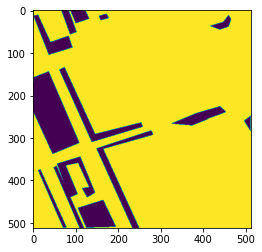

In [ ]:
plt.imshow(test_label[0,:,:,0])

In [ ]:
test_predict = ddn.predict([test_im1,test_im2])[0]
#test_predict = tf.nn.softmax(test_predict)
test_predict = tf.argmax(test_predict,axis=-1)

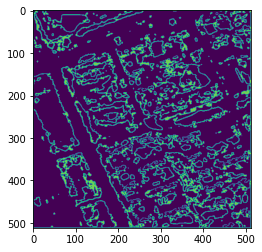

In [ ]:
plt.imshow(test_predict[0,:,:])

In [ ]:
!tensorboard dev upload \
  --logdir logs/gradient_tape \
  --name "DDN 2 epochs cat_entropy loss" \
  --description "Custom LR sqrt schedule" \

2021-03-01 22:23:00.704436: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs/gradient_tape

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A